# CNN-VAE Exploration

The aim of this notebook was for CNN-VAE exploration. 

* as the wildfires are images with spatial relationships between the pixels, convolutions *should* work well. In particular, they should be able to understand the shape very well and generate plausibe images even if they are blurred.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

from src.generative.utils import (
    get_device,
    sequential_undersample_3d_arr,
    sequential_train_val_split,
    test_data_metrics,
)

from src.generative.plotting import (
    plot_batch_recon_images,
    plot_single_raw_and_dataset_idx_image,
)

from src.generative.model import CVAE
from src.generative.training import train_vae

from src.generative.dataset import WildfireImageDataSet

%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
DEVICE = get_device()

No GPU available! (device = cpu)


#### Data Loading
* A user will need to download the wildfire data available at `https://companyname.sharepoint.com/sites/projectname/Shared%20Documents/example-document.docx`
* the current set up runs given that the `.npy` wildfire data is stored in a `data/` DIR.

In [3]:
# load in the data.
train_data = np.load("data/Ferguson_fire_train.npy")
test_data = np.load(f"data/Ferguson_fire_test.npy")

print("** (raw) DATA INFO **")
print(f"train: type={type(train_data)}, dims={train_data.shape}")
print(f"test: type={type(test_data)}, dims={test_data.shape}")

** (raw) DATA INFO **
train: type=<class 'numpy.ndarray'>, dims=(12500, 256, 256)
test: type=<class 'numpy.ndarray'>, dims=(5000, 256, 256)


In [4]:
train_data_us = sequential_undersample_3d_arr(arr=train_data, sequence_jump=1)

X_train, X_val = sequential_train_val_split(
    train_data=train_data_us, sequence_jump=3, start_offset=2, jump_multiplier=3
)


** (undersampled) data info **
X_train_undersampled: (12500, 256, 256)

** (split) data info (w/ jump=3)**
X_train: (11111, 256, 256)
X_val: (1389, 256, 256)


In [5]:
transform = transforms.Compose(
    transforms=[
        transforms.ToTensor(),
    ]
)

train_dataset = WildfireImageDataSet(data=X_train, transform=transform)
val_dataset = WildfireImageDataSet(data=X_val, transform=transform)
test_dataset = WildfireImageDataSet(data=test_data, transform=transform)

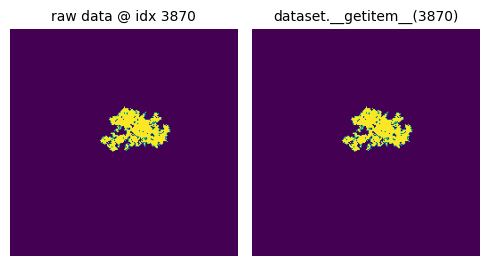

In [6]:
plot_single_raw_and_dataset_idx_image(
    data=X_train,
    dataset=train_dataset,
    idx=3870,
    figsize=(5, 3),
    # cmap="hot",
)

In [7]:
# KEY PARAMETERS for DATA
batch_size = 32
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

In [8]:
# get a batch from the train_loader:
train_batch = next(iter(train_loader)).float()
print(train_batch.shape)

torch.Size([32, 1, 256, 256])


### CNN Setups

* we tried a range of CNN-VAE setups. We tried:
  * convolving **down** to a linear layer & DEEP i.e. `256 -> 128 -> 64 -> linear layers -> **latent space** -> linear layers -> 64 -> 128 -> 256` 
  * convolving **down** to a linear layer & SHALLOW i.e. `32 -> 16 -> 8 -> linear layers -> **latent space** -> linear layers -> 8 -> 16 -> 32`
  * convolving **up** to a linear layer & DEEP i.e. `32 -> 64 -> 128 -> 256 -> linear layers -> latent space -> linear layers -> 256 -> 128 -> 64 -> 32`
  * convolving **up** to a linear layer & SHALLOW i.e. `3 -> 8 -> 16 -> 64 -> linear layers -> latent space -> linear layers -> 64 -> 16 -> 8 -> 3`

* all of the above we tried maxpooling + upsampling  OR stride convolutions + strided deconvolutions.

* we also tried large to small kernel sizes i.e `7 --> 5 --> 3` with the intution that we can capture large scale features at the start of the convolutions and then extract the small scale features later on.


### Results / Comments

* as expected, the CNN-VAE was much "heavier" than the FCVAE. Typically, all of the deeper CNN-VAE structures all needed GPU where as all of the FCVAEs that we trained i.e in `FCVAE_final_training.ipynb` and `FCVAE_grid_search.ipynb` could all be trained on a CPU. The CNN-VAEs took much longer to train on average as well. 
* interestingly, the deeper the CNN-VAE, the worse results when also considering training time. We were also comparing to the FCVAEs, in particular to the previous "baseline" of `[512 -> 256 -> 128 -> 16]: lr=0.001: nn.ReLU(): batchsize = 32` that we got running very early on in the project.
* After a lot of testing, we noticed that the shallower CNN-VAE networks that were using a convolve down to latent to up i.e. `32 -> 16 -> 8 -> linear layers -> **latent space** -> linear layers -> 8 -> 16 -> 32` worked the best and with large to small kernel sizes i.e. `7 --> 5 --> 3`. Also, these shallower arcitechtures were comparable to the training times of the FCVAEs meaning that we were able to compare both the training time and recons. 
* Similar to the previous "baseline", the shallower / simpler the better and we put this down to the data not being too complicated and that using deeper networks, the actual netowrks sturggles to extract the correct information. However, the "best" CNN-VAE that we explored, still produced blurry images and was "worse" at generated images compared to the FCVAEs. 

[best CNN-VAE]: `32 -> 16 -> 8 -> linear layers -> **latent space** -> linear layers -> 8 -> 16 -> 32 w/ kernels: [7, 5, 3]`

In [32]:
model = CVAE(
    input_image_dims=(1, 256, 256),
    latent_dims=64,
    kernel_sizes=[7, 5, 3],
    filter_sizes=[32, 16, 8],
    h_dim=256,
    device=DEVICE,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=False)

model, train_losses, val_losses = train_vae(
    n_epochs=30,
    model=model,
    optimizer=optimizer,
    scheduler=None,
    train_loader=train_loader,
    val_loader=val_loader,
    model_save_path=None,
    use_liveloss=False,
    device=DEVICE,
)

Epoch: 1/10 | Batch: 86/463:  12%|█▏        | 549/4630 [00:18<02:05, 32.46batch/s, loss=300]     

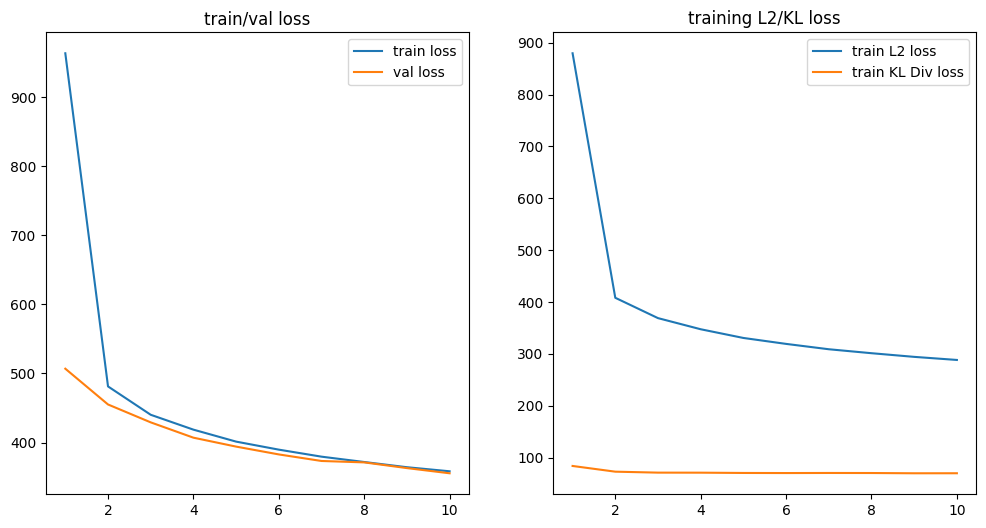

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# train/val losses plot
axs[0].plot(np.arange(1, len(train_losses) + 1, 1), train_losses, label="train loss")
axs[0].plot(np.arange(1, len(val_losses) + 1, 1), val_losses, label="val loss")
axs[0].set_title("train/val loss")
axs[0].legend(loc="best")

# kl and mse loss plot
axs[1].plot(
    np.arange(1, len(train_losses[1]) + 1, 1), train_losses[1], label="train L2 loss"
)
axs[1].plot(
    np.arange(1, len(train_losses[2]) + 1, 1),
    train_losses[2],
    label="train KL Div loss",
)
axs[1].set_title("training L2/KL loss")
axs[1].legend(loc="best")

* the training plots are good.

random idxs = tensor([6, 0, 5, 0, 6])


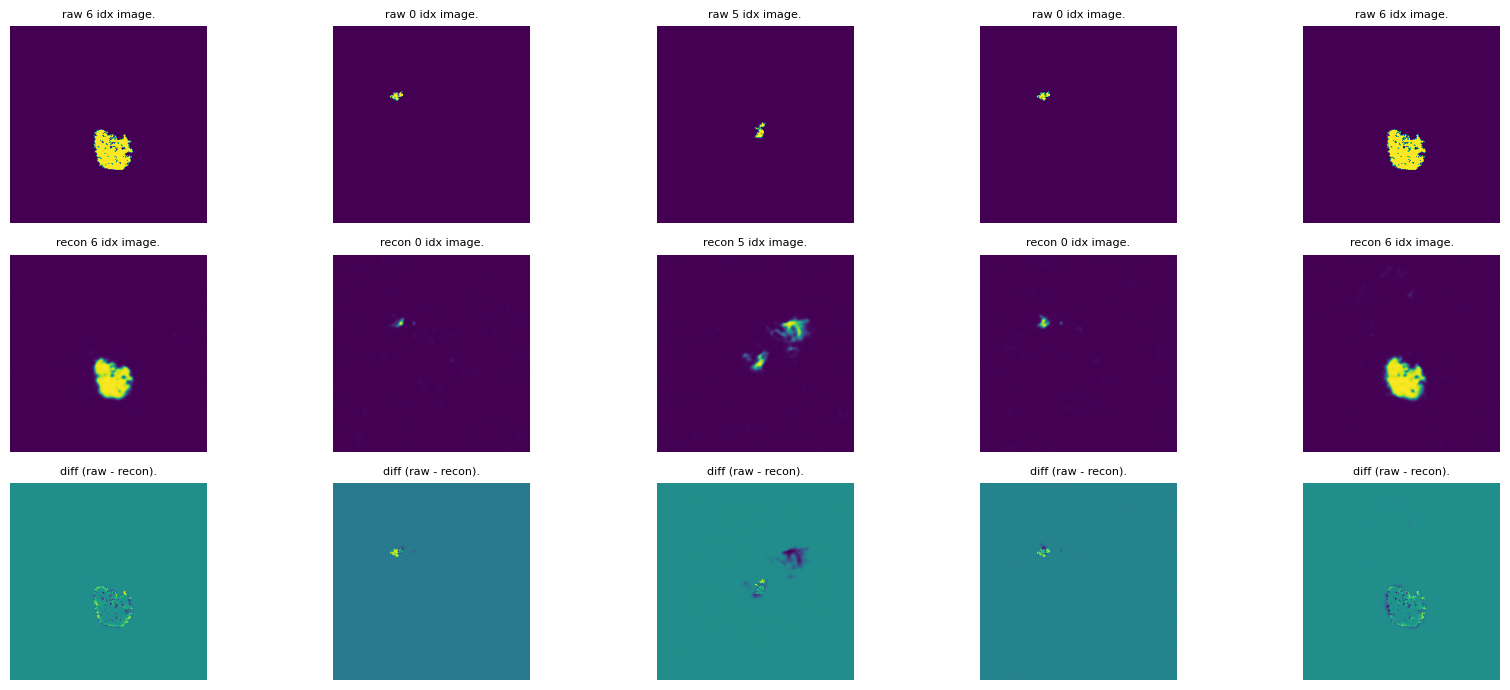

In [72]:
plot_batch_recon_images(
    model=model,
    data_loader=train_loader,
    num_images=5,
    device=DEVICE,
)

* as you can see, the images are just more blurry when using the "best" CNN-VAE compared to the FCVAE.
* the shape of the wildfire is well detected but blurry.
* also, what is intersting is that it seems with the CNN-VAEs, the latent space was less well behaved. If you look at the middle image, artefacts are produces that look continuous and blurry.

In [34]:
criterion = nn.MSELoss(reduction="sum")
test_mse = test_data_metrics(model, criterion, data_loader=test_loader, device=DEVICE)
test_mse

590.1953125

### Conclusions / Results:
* Considering the computational complexity alone and the good performance of the previous "baseline", in order for us to justify using a CNN-VAE, it had to produce significantly better images, both recon and generative. Whilst the CNN-VAEs are able to capture the wildfires shape, the recons are too blurry. We explored many CNN-VAE arcitectures and trained them sufficiently using GPU but we think that the data is better suited to the FCVAEs. They dont produce as much blur and they are much simpler in terms of computational complexity. \

* moving on from this notebook, we decided to try and get the best FCVAE we could and then also if we had time explore more VAE options such as `VQVAE` either using CNNs or fully connected.

* the analysis for the "best FCVAE" is in `FCVAE_tuning.ipynb`.